# TP 1: Introduction à la cartographie

## Contexte

On a des observations $z(\mathbf{x}_1),\dots, z(\mathbf{x}_n)$ d'un phénomène en des points $\left(\mathbf{x}_i\right)_{i=1}^n$ d'un domaine spatial $\mathcal{D} \subset \mathbb{R}^d$, et on veut prédire la valeur de $z(\mathbf{x}_0)$ en un nouveau point $\mathbf{x}_0$ pour lequel on n'a pas d'observations

Les méthodes employées ici sont des prédicteurs linéaires : 

$$\hat{z}(\mathbf{x}_0) = \sum_{i=1}^{n} \lambda_i(\mathbf{x}_0)z(\mathbf{x}_i)$$

## Cadre du TP

Ici, dans le cadre de ce TP, les $n$ observations sont placées dans un fichier csv. On va ensuite vouloir prédire le phénomène dans l'ensemble du domaine, en des points stockées dans un second fichier csv. Comme l'objectif ici est d'explorer différentes approches, on a en réalité connaissance des vraies valeurs du phénomène dans l'ensemble du domaine, et on va notamment pouvoir visualiser les vraies cartes et les comparer à nos prédictions.

### On importe les libraries nécessaires

Vous devrez probablement télécharger certaines librairies. Exemple : pip install pandas

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.optimize import minimize


## 2 fonctions importantes : 

- La fonction "plot_data" permet d'afficher les cartes à partir d'un tableau numpy.array. La premier colonne du tableau correspond à l'abscisse, la deuxième à l'ordonnée, et la troisième à la valeur du phénomène. Eventuellement, un tableau numpy.array contenant les points d'observations peut être renseigné sous l'argument "df_obs", afin de visualiser les localisations de ces points. Les paramètres vmin et vmax permettent de fixer éventuellement des bornes pour l'échelle de couleur utilisée. Il sera vivement conseillé d'utiliser toujours l'échelle de couleur associée aux vraies valeurs du phénomène.
- La fonction "dist_point_obs" prend en argument un point x (donc un vecteur en 2 dimensions), un tableau "df_obs" contenant les points d'observations, et retourne un vecteur contenant les distances euclidiennes entre le point x et chaque point de df_obs.

In [9]:
def plot_data(df, df_obs = None, vmin = None, vmax = None, titre = ""):
    if vmin is None: vmin = min(df[:,2])
    if vmax is None: vmax = max(df[:,2])
    fig, ax = plt.subplots()
    im = ax.tricontourf(
    df[:,0], df[:,1], df[:,2],
    levels=100, cmap="magma")
    fig.colorbar(plt.cm.ScalarMappable(norm=colors.Normalize(vmin, vmax), cmap='magma'),ax=ax, orientation='vertical', label='')
    if df_obs is not None: plt.scatter(df_obs[:,0], df_obs[:,1], c='white', edgecolor='black', s=20, label='Observations')    
    ax.set_title(titre)  

    plt.show()

def dist_point_obs(x, df_obs):
    dists = np.sqrt(np.sum((df_obs[:, :2] - x)**2, axis=1))
    return(dists)


# Partie I : Données synthétiques

Ici, on utiliser les observations stockées dans le tableau "df_obs_1.csv", et on va vouloir prédire le phénomène en tous les points du tableau "data_1.csv". Pour ces 2 tableaux, les 2 premières colonnes correspondent aux coordonnées spatiales, et la 3e à la valeur du phénomène.

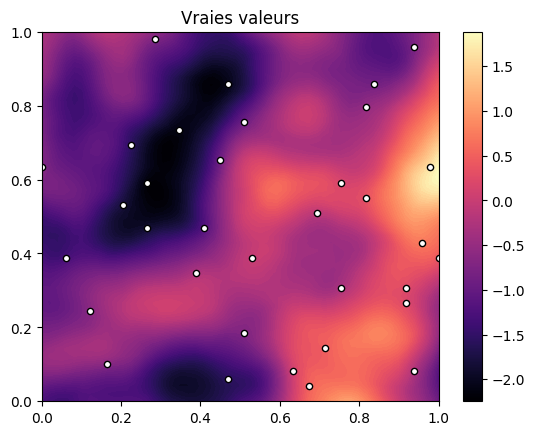

In [11]:
df = pd.read_csv("data/data_1.csv").values #les données à prédire
df_obs = pd.read_csv("data/df_obs_1.csv").values #les données d'observation
plot_data(df, df_obs, titre = "Vraies valeurs") #afficher les données à predire

## I.1 Nearest neighbor

Une première méthode possible est simplement d'attribuer à $\hat{z}(\mathbf{x}_0)$ la valeur de son plus proche voisin parmi les observations $\left(z(\mathbf{x}_i)\right)_{i=1}^{n}.$ 

Formellement, cela revient à $$\hat{z}(\mathbf{x}_0) = z(\mathbf{x}_i) \text{ où } i=\underset{j = 1,\dots,n}{\text{arg}\min}\lVert \mathbf{x}_{j}-\mathbf{x}_0 \rVert$$

On a bien un prédicteur linéaire $\hat{z}(\mathbf{x}_0) = \sum_{i=1}^{n} \lambda_i(\mathbf{x}_0)z(\mathbf{x}_i)$ avec 
$$\lambda_i(\mathbf{x}_0) = \mathbb{1}_{\lVert \mathbf{x}_i - \mathbf{x}_0 \rVert = \underset{j = 1,\dots,n}{\min} \lVert \mathbf{x}_j - \mathbf{x}_0 \rVert }
$$



#### Question 1 : Coder la fonction en complétant le code ci-dessous

In [1]:
def nearest_neighbor(x0, df_obs):
    return 


On va appliquer la fonction à chaque point de notre domaine, et stocker la prédiction dans un tableau df_nn. 

#### Question 2: Observer la prédiction en utilisant la fonction plot_data. Veuillez bien à renseigner vmin et vmax pour avoir la même échelle de couleur que pour la carte des vraies valeurs.

In [ ]:
pred_nn = np.apply_along_axis(lambda x:nearest_neighbor(x, df_obs), 1, df[:,:2]) #appliquer la fonction nearest neighbor à chaque point de df
df_nn =  np.column_stack((df[:,:2], pred_nn)) #créer un tableau avec les coordonnées des points et la valeur prédite


## I.2 K Nearest neighbors

Afin d'obtenir des prédictions plus lisses, une méthode possible est d'attribuer à $\hat{z}(\mathbf{x}_0)$ la valeur moyenne de ses k plus proches voisins parmi les observations $\left(z(\mathbf{x}_i)\right)_{i=1}^{n}.$ 

On a encore un prédicteur linéaire $\hat{z}(\mathbf{x}_0) = \sum_{i=1}^{n} \lambda_i(\mathbf{x}_0)z(\mathbf{x}_i)$ avec 
$$\lambda_i(\mathbf{x}_0) = \frac{1}{K}\mathbb{1}_{\mathbf{x}_i \in V_K(\mathbf{x}_0)} \text{ où } V_K(\mathbf{x}_0) \text{ est l'ensemble des }K \text{ plus proches voisins de }\mathbf{x}_0 
$$
 On peut écrire
$$V_K(\mathbf{x}_0) = \left\{i \in 1,\dots,n, \text{card}\{j \in 1,\dots,n, \lVert \mathbf{x}_j -\mathbf{x}_0\rVert \leq \lVert \mathbf{x}_i -\mathbf{x}_0\rVert\} = K\right\}$$


#### Question 3 : Coder la fonction en complétant le code ci-dessous

In [2]:
def k_nearest_neighbor(x0,k, df_obs):
    return 

#### Question 4 : Calculer la prédiction en chaque point du domaine (i.e. chaque point du tableau df) avec $K=3$, et stocker les résultats dans un tableau "df_knn".Observer la prédiction en utilisant la fonction plot_data

## I.3 Inverse distance

On peut également obtenir des prédictions continues, en utilisant des coefficients qui sont liées aux distances à tous les points d'observations. L'idée est d'utiliser un coefficient $\lambda_i(\mathbf{x}_0)$ proportionnel à l'inverse de la distance $\lVert \mathbf{x}_i - \mathbf{x}_0\rVert^\alpha.$

Le prédicteur est linéaire et s'écrit $\hat{z}(\mathbf{x}_0) = \sum_{i=1}^{n} \lambda_i(\mathbf{x}_0)z(\mathbf{x}_i)$ avec 
$$ \lambda_i(\mathbf{x}_0) = \frac{1}{\lVert \mathbf{x}_i - \mathbf{x}_0\rVert^\alpha}\frac{1}{S_\alpha(\mathbf{x}_0)} \text{ où } S_\alpha(\mathbf{x}_0) = \sum_{j=1}^{n}\frac{1}{\lVert \mathbf{x}_j - \mathbf{x}_0\rVert^\alpha}
$$


#### Question 5 : Coder la fonction en complétant le code ci-dessous

In [3]:
def inverse_distance(x0,alpha, df_obs):
    return


#### Question 6 : Calculer la prédiction en chaque point du domaine (i.e. chaque point du tableau df) avec $\alpha=2$, et stocker les résultats dans un tableau "df_invdist".Observer la prédiction en utilisant la fonction plot_data

## I.4 Calcul de l'erreur

Afin d'évaluer la performance de chacune des méthodes, il est important de calculer des grandeurs quantitatives. Une grandeur très couramment utilisée est la Root Mean Square Error (RMSE), calculée entre un vecteur de prédiction $\hat{\mathbf{z}} = \left(\hat{z}_j\right)_{j=1}^{n_\text{pred}}$ et les vraies valeurs du phénomène associé $\mathbf{z} = \left(z_j\right)_{j=1}^{n_\text{pred}}.$

On a $$
\mathrm{RMSE}(\mathbf{z},\hat{\mathbf{z}}) =
\sqrt{\frac{1}{n_\text{pred}}\sum_{i=1}^{n_\text{pred}} (z_i - \hat{z}_i)^2}.
$$

#### Question 7 : Coder la fonction RMSE en complétant le code ci-dessous, et calculer l'erreur pour chacune des 3 prédictions

In [5]:
def RMSE(ypred, ytrue):
    return 


## I.5 Tuning des paramètres

#### Question 8 : Calculer et afficher l'évolution de l'erreur lorsque le paramètre $K$ de la méthode des K-voisins varie

#### Question 9 : Faire pareil avec le paramètre $\alpha$ de la méthode de la distance inverse

#### Question 10 : Effectuer une optimisation plus précise du paramètre $\alpha$ en utilisant la fonction "minimize" du package scipy.optimize.

Documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

#### Question 11 : Afficher la carte prédite avec le paramètre $\alpha$ optimale


# Partie II : Données conductivité

On va maintenant étudier des données de conductivité, mesurées avec un appareil CMD explorer (voir http://gfinstruments.cz/index.php?menu=gi&smenu=iem&cont=cmd_&ear=ov). On va se baser sur les observations contenues dans le tableau "df_obs_conductivity.csv", et on va prédire cette grandeur en tous les points du tableau "data_conductivity.csv". Pour ces 2 tableaux, les 2 premières colonnes correspondent aux coordonnées spatiales, et la 3e à la conductivité.

#### Question 1 : Suivre les mêmes étapes que pour la partie 1, afin notamment d'identifier la meilleur prédiction parmi les méthodes vues en cours

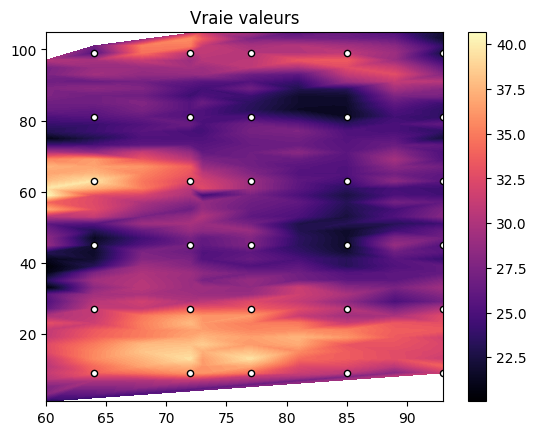

In [12]:
df_condu = pd.read_csv("data/data_conductivity.csv").values  #les données à prédire
df_obs_condu = pd.read_csv("data/df_obs_conductivity.csv").values #les données d'observation
plot_data(df_condu,df_obs = df_obs_condu, titre = "Vraie valeurs") #afficher les données à prédire

# Partie III : Données de température

On va ici étudier des données de température dans une région donnée du monde. Comme précédemment, on va se baser sur des observations, stockées dans la base de données "df_obs_temperature.csv". La prédiction doit s'effectuer en les points du domaine stockées dans le tableau "df_temperature.csv". Pour ces 2 tableaux, les 2 premières colonnes correspondent respectivement à la longitude et la latitude, et la troisième correspond à la température. Pour information, ces données ont été mesurée le 01/02/2025. 

Il est important de noter que la notion de distance n'est pas triviale sur une sphère comme la surface de la Terre. On ne rentre pas dans les détails théoriques ici, et on va considérer la distance "à vol d'oiseau" sur la sphère, aussi appelée distance orthodromique. Cette distance est calculée par la fonction "distance_earth" ci-dessous, qui prend en argument 2 points définit par leur longitude et latitude.

Pour étudier le lien entre les température en un point A et un point B, on a également un autre tableau "df_temperature_3points.csv", qui contient les données de température du mois de février 2025 pour 3 points, appelés A, B et C. Le tableau contient 5 colonnes : longitude, latitude, la date, la température, et une colonne "point" qui indique si il s'agit du point A,B ou C.

### Distance sur la terre

Comme expliqué plus haut, la fonction distance_earth calcule la distance entre 2 points à partir de leurs coordonnées (longitude, latitude).
La fonction dist_point_obs_earth calcule prend en argument un point x défini par ses coordonnées (longitude, latitude), et un tableau "df_obs" contenant les points d'observations, et retourne un vecteur contenant les distances prenant en compte la surface de la terre entre le point x et chaque point de df_obs, 

In [25]:
def distance_earth(point1, point2): # Cette distance prend en argument 2 points définis par leur couple (longitude, latitude) et renvoie la distance 
    R = 6371.0  #rayon de la terre
    lat1, lon1, lat2, lon2 = map(np.radians, [point1[1], point1[0], point2[1], point2[0]]) #conversion en radian
    dlat = lat2 - lat1 #écart de latitude
    dlon = lon2 - lon1 #écart de longitude
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2 
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def dist_point_obs_earth(x, df_obs): #distances entre un point x et chaque point de df_obs
    dists = np.apply_along_axis(lambda vec: distance_earth(x, vec), axis=1, arr=df_obs) 
    return(dists)

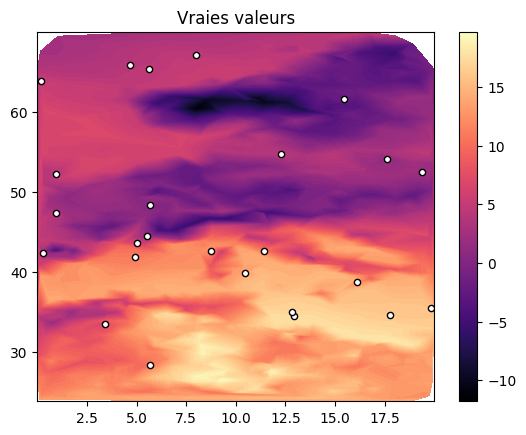

In [6]:
df_temp = pd.read_csv("data/df_temperature.csv").values #données à prédire
df_obs_temp = pd.read_csv("data/df_obs_temperature.csv").values #données d'observations
df_3points = pd.read_csv("data/df_temperature_3points.csv") # 3 points A,B et C pour lesquels on a des données de température au cours du mois de février

plot_data(df_temp,df_obs = df_obs_temp, titre = "Vraies valeurs") #Visualisation des données à prédire

### Visualisation géographique

La carte ci-dessous représente la zone de prédiction visée. On reconnaît ici une partie de l'Europe et le nord de l'Afrique. On repère aussi les 3 points A, B, C pour lesquels on va regarder les dépendances de température en se basant sur les données du mois de février 2025. Il est important de noter ici que la distance entre A et C et la distance entre A et B sont presques égales, et que A et C ont presque la même longitude et A et B des longitudes très proches.

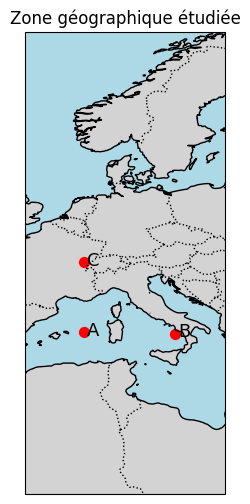

In [27]:
points = df_3points[["longitude","latitude","point"]].drop_duplicates() #Base de données avec seulement les coordonnées des points A,B et C et leur label

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes(projection=ccrs.PlateCarree())

# Fond de carte
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Tracer les points
ax.scatter(points["longitude"], points["latitude"], color='red', s=50, transform=ccrs.PlateCarree())

# Ajouter les labels A, B et C
for i, row in points.iterrows():
    ax.text(row["longitude"] + 0.3, row["latitude"] -0.3, row["point"],
            transform=ccrs.PlateCarree(), fontsize=13)

# Ajuster la vue
ax.set_extent([
    df_temp[:,0].min() ,
    df_temp[:,0].max() ,
    df_temp[:,1].min() ,
    df_temp[:,1].max() ,
], crs=ccrs.PlateCarree())


ax.set_title("Zone géographique étudiée")
plt.show()

## III.1 Etude des données en A,B et C

#### Question 1 : Calculer la distance entre A et B d'une part, et B et C d'autre part

In [ ]:
coordA = points.values[0,:2] #coordonnées du point A
coordB = points.values[1,:2] #coordonnées du point B
coordC = points.values[2,:2] #coordonnées du point C

## Calcul de covariance et corrélation

#### Définitions

- La **variance** d'une variable aléatoire réelle nous donne l'espérance de l'écart quadratique à la moyenne : 

$$\mathbb{V}(X) = \mathbb{E}\left((X-\mathbb{E}(X))^2\right)$$

- Si $X$ et $Y$ sont de carré intégrable (i.e. leur variance est définie), la **covariance** entre $X$ et $Y$ est définie et permet de mesurer comment les 2 v.a. évoluent ensemble : 
$$\text{cov}(X,Y) = \mathbb{E}\left((X-\mathbb{E}(X))(Y-\mathbb{E}(Y))\right)$$

- **Le coefficient de corrélation** est une covariance normalisée, définie quand $\mathbb{V}(X)>0$ et $\mathbb{V}(Y)>0,$ par
$$\rho(X,Y) = \frac{\text{cov}(X,Y)}{\sqrt{\mathbb{V}(X)\mathbb{V}(Y)}}$$

#### Estimation de ces grandeurs

On considère 2 variables aléatoires $(X,Y)$, $(X_1,Y_1), \dots, (X_n,Y_n)$ n couples aléatoires indépendants et suivant la même distribution que $(X,Y)$. 

- Un estimateur de la variance de $X$ est alors $$S_n = \frac{1}{n-1} \sum_{i=1}^{n} (X_i - M_n)^2 \text{ avec }M_n = \frac{1}{n}\sum_{i=1}^{n} X_i$$
- Un estimateur de la covariance entre $X$ et $Y$ est $$C_n = \frac{1}{n-1} \sum_{i=1}^{n} (X_i - M_n)(Y_i- \tilde{M}_n) \text{ avec }M_n = \frac{1}{n}\sum_{i=1}^{n} X_i \text{ et } \tilde{M}_n = \frac{1}{n}\sum_{i=1}^{n} Y_i$$
  

#### Question 2 : Visualiser la température en A en fonction de la température en B, puis la température en A en fonction de la température en C. Commenter.

In [ ]:
vecA = df_3points[df_3points["point"] == "A"]["t"].values #Données de température en février pour le point A
vecB = df_3points[df_3points["point"] == "B"]["t"].values #Données de température en février pour le point B
vecC = df_3points[df_3points["point"] == "C"]["t"].values #Données de température en février pour le point C

#### Question 3 : Coder une fonction qui permet 2 calculer la corrélation empirique entre 2 vecteurs

In [7]:
def func_correlation(v1,v2):
    return



#### Question 4 : Calculer la corrélation entre les températures en A et en B d'une part, et en A et C d'autre part. Commenter

## III.2 Prediction par distance inverse classique

Cette analyse va nous aider à peut-être améliorer la prédiction. Revenons tout d'abord au cas classique : on a nos observations dans un tableau, et on veut faire de la prédiction dans tout le domaine par distance inverse.

#### Question 5 : Modifier la fonction inverse_distance précédemment créée avec la distance adaptée au cas de la sphère

In [8]:
def inverse_distance_earth(x0,df_obs,alpha = 1):
    return


#### Question 6 : Regarder l'évolution de l'erreur de prédiction en fonction de $\alpha$

#### Question 7 : Trouver le $\alpha$ optimal grâce à la fonction minimize, et afficher la carte prédite associée

## III.3 Amélioration de la prédiction



#### Question 8 : Au regard des observations faites dans la partie III.1 sur les points A, B et C, proposer une modification de la distance prise en compte dans la fonction "inverse_distance" afin d'améliorer la prédiction. Si cette fonction fait intervenir un paramètre, l'optimiser. Conserver le $\alpha$ optimal calculé précédemment pour votre fonction inverse_distance améliorée.



#### Question 9 : Afficher la prédiction obtenue avec cette nouvelle distance optimisée et calculer la RMSE associée. Comparer le gain relatif par rapport à la RMSE précédente.